In [3]:
import pandas as pd
import os; os.getcwd()
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [4]:
# Load pandas from zip
balanced_panel_df = pd.read_stata("/home/lordflaron/Documents/ethiopia-tech-adoption/data/full_panel_rain_traj.dta")


balanced_panel_df[["LAT_DD_MOD", "LON_DD_MOD"]] = balanced_panel_df.groupby('holder_id')[["LAT_DD_MOD", "LON_DD_MOD"]].transform('mean')


/usr/lib/python3.9/site-packages/pandas/io/stata.py:1457: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  warnings.warn(msg, UnicodeWarning)


## Create Map of Households

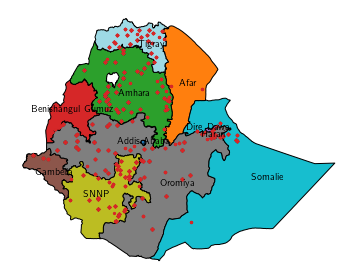

In [5]:
map = gpd.read_file("data/ethiopiaworeda/Eth_Woreda_2013.shp").replace({'REGIONNAME' : {'Beneshangul Gumu' : 'Benishangul Gumuz',
                                                                                       'Hareri' : 'Harari',
                                                                                       'SNNPR' : 'SNNP',
                                                                                       'Oromia' : 'Oromiya',
                                                                                       'Somali' : 'Somalie',
                                                                                       'Gambela' : 'Gambella'}})

# Get number of households per region
# hhids = df.drop_duplicates(['holder_id', 'wave']).groupby(['region', 'wave'])['holder_id'].count()

fig, ax = plt.subplots()

ax.set_axis_off()

with mpl.rc_context(rc={'text.usetex': True}):
    merged_map = (
        map
        .dissolve('REGIONNAME')
        .reset_index('REGIONNAME')
        .to_crs(epsg= 4326)
    )
    
    merged_map.plot(legend=True,
                    legend_kwds={'label' : "Number of Households"},
                ax=ax,
                cmap = 'tab20',
                missing_kwds={'color': 'lightgrey'},
                edgecolor='black')
    
    merged_map.apply(lambda x: ax.annotate(text=x['REGIONNAME'], xy=x.geometry.representative_point().coords[0], ha='center'), axis=1)
    
    panel_gdf = gpd.GeoDataFrame(balanced_panel_df.dropna(subset=["LON_DD_MOD", "LAT_DD_MOD"]), 
                                 geometry=gpd.points_from_xy(balanced_panel_df["LON_DD_MOD"].dropna(),
                                                             balanced_panel_df["LAT_DD_MOD"].dropna()), crs=4326).plot(ax=ax, color='tab:red', markersize=5)


    plt.tight_layout()

    plt.savefig("results/figures/map_hhids.pdf", format='pdf', dpi=160)

## Create Summary Table

In [54]:
def add_note(table, note, n):
    
    return table.replace("\\end{tabular}\n\\end{table}", f"\\multicolumn{{{n}}}{{l}}{{Note: {note}}}\n\\end{{tabular}}\n\\end{{table}}")

fancy_rename_dict = {'parcesizeHA_wiz' : 'Parcel Size',
              'hhlabor' : 'Household Labor for Harvest (Days)',
              'hiredlabor' : 'Hired Labor for Harvest (Days)',
              'age_head_wiz' : 'Age of Household Head',
              "female"  : "Sex of Household Head",
              "asset_index" : "Asset Index",
              "title" : "Does the HH have a title to this land?",
              'dist_road_wiz' : 'Distance to Nearest Asphalt Road (km)',
              'dist_borderpost_wiz' : 'Distance to Nearest Border (km)',
              'dist_market_wiz' : 'Distance to Nearest Market (km)',
              'dist_popcenter_wiz' : 'Distance to Nearest Population Center (km)',
              'dist_admctr_wiz' : 'Distance to Nearest Administrative Center (km)',
              'fertcosts' : 'Fertilizer Costs',
              'dirrigation' : 'Do you irrigate?',
              'numadult' : 'Number of Adults',
              'numwomen' : 'Number of Women',
              'numchildren' : 'Number of Children',
              "h_tot" : "Total Rainfall (mm)",
            'YIELD_cropcutdry_tr' : 'Crop Cut Dry Yield (kg/ha)',
            'YIELD_selfr_tr' : 'Self-reported Yields (kg/ha)'
              }

summary_latex = (
    balanced_panel_df
    .assign(female = lambda df: (df['sex_head'] == 2).astype(int))
    .rename({'wave' : "Wave"}, axis=1)
    [list(fancy_rename_dict.keys()) + ['Wave']]
    .groupby('Wave')
    .describe()
    .loc[:, (slice(None), ['count', 'mean', 'std'])].T
    .rename({'count' : 'N', 'mean' : 'Mean', 'std' : 'Std. Dev.', 'min' : 'Min', 'max' : 'Max'}, axis=0)
    .rename(fancy_rename_dict)
    .applymap("{:,.2f}".format)
    .to_latex(label = "tbl:summary",
              caption="Summary Statistics for Households",
              longtable=True)
    )

with open("results/tables/summary.tex", 'w') as f:
    f.write(add_note(summary_latex, "Parcel size, yield and distance variables winsorized at the 1\% level.", 6))


In [40]:
summary_latex

wave                                                              1.0  \
Parcel Size                                    N          1157.000000   
                                               Mean          0.305182   
                                               Std. Dev.     0.353534   
Household Labor for Harvest (Days)             N          1157.000000   
                                               Mean         44.511668   
                                               Std. Dev.    70.074399   
Hired Labor for Harvest (Days)                 N          1157.000000   
                                               Mean          4.173725   
                                               Std. Dev.    25.530972   
Age of Household Head                          N          1148.000000   
                                               Mean         44.127178   
                                               Std. Dev.    14.673473   
Sex of Household Head                          N          1157.000000   
                                               Mean          0.158168   
                                               Std. Dev.     0.365056   
Asset Index                                    N          1154.000000   
                                               Mean          2.954073   
                                               Std. Dev.     1.307317   
Does the HH have a title to this land?         N          1155.000000   
                                               Mean          0.435498   
                                               Std. Dev.     0.496036   
Distance to Nearest Asphalt Road (km)          N          1155.000000   
                                               Mean         16.029351   
                                               Std. Dev.    16.037259   
Distance to Nearest Border (km)                N          1155.000000   
                                               Mean        241.808745   
                                               Std. Dev.   111.738380   
Distance to Nearest Market (km)                N          1155.000000   
                                               Mean         65.652381   
                                               Std. Dev.    49.632084   
Distance to Nearest Population Center (km)     N          1155.000000   
                                               Mean         40.303290   
                                               Std. Dev.    29.322401   
Distance to Nearest Administrative Center (km) N          1155.000000   
                                               Mean        165.472900   
                                               Std. Dev.   117.303191   
Fertilizer Costs                               N             0.000000   
                                               Mean               NaN   
                                               Std. Dev.          NaN   
Do you irrigate?                               N           759.000000   
                                               Mean          0.042161   
                                               Std. Dev.     0.201088   
Number of Adults                               N          1155.000000   
                                               Mean          2.754112   
                                               Std. Dev.     1.269621   
Number of Women                                N          1155.000000   
                                               Mean          1.366234   
                                               Std. Dev.     0.695420   
Number of Children                             N          1155.000000   
                                               Mean          1.824242   
                                               Std. Dev.     1.420122   
Total Rainfall (mm)                            N          1155.000000   
                                               Mean        766.667532   
                                               Std. Dev.  

In [8]:
traj_table = balanced_panel_df['trajectory'].value_counts().to_latex(caption='Trajectories of Households', 
                                                          label='tbl:trajectories')

with open("results/tables/traj.tex", 'w') as f:
    f.write(traj_table.replace('[', '(').replace(']', ')').replace('trajectories', 'Trajectories'))